<img src="./images/DLI_Header.png" style="width: 400px;">

# Data Augmentation

So far, we've selected a model architecture that vastly improves the model's performance, as it is designed to recognize important features in the images. The validation accuracy is still lagging behind the training accuracy, which is a sign of overfitting: the model is getting confused by things it has not seen before when it tests against the validation dataset.

In order to teach our model to be more robust when looking at new data, we're going to programmatically increase the size and variance in our dataset. This is known as [*data augmentation*](https://link.springer.com/article/10.1186/s40537-019-0197-0), a useful technique for many deep learning applications.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only the features that are truly important in classification, allowing it to generalize better.

## Objectives

* Augment the ASL dataset
* Use the augmented data to train an improved model
* Save the well-trained model to disk for use in deployment

## Preparing the Data

As we're in a new notebook, we will load and process our data again. To do this, execute the following cell:

In [1]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

## Model Creation

We will also need to create our model again. To do this, execute the following cell. You will notice this is the same model architecture as the last section:

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

## Data Augmentation

Before compiling the model, it's time to set up our data augmentation.

Keras comes with an image augmentation class called `ImageDataGenerator`. We recommend checking out the [documentation here](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). It accepts a series of options for augmenting your data. Later in the course, we'll have you select a proper augmentation strategy. For now, take a look at the options we've selected below, and then execute the cell to create an instance of the class:

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

Take a moment to think about why we would want to flip images horizontally, but not vertically. When you have an idea, reveal the text below.

Our dataset is pictures of hands signing the alphabet. If we want to use this model to classify hand images later, it's unlikely that those hands are going to be upside-down, but, they might be left-handed. This kind of domain-specific reasoning can help make good decisions for your own deep learning applications.

## Batch Size
Another benefit of the `ImageDataGenerator` is that it [batches](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/) our data so that our model can train on a random sample.

If the model is [truly random](http://sites.utexas.edu/sos/random/), meaning that the data is properly shuffled so it's fair like a deck of cards, then our sample can do a good job of representing all of our data even though it is a tiny fraction of the population. For each step of the training, the model will be dealt a new batch.

In practice, a batch size of 32 and 64 does well. Run the cell below to see what kind of batches we'll be training our model with. Is our randomizer fairly randomizing? Are all of the images recognizable ASL letters?

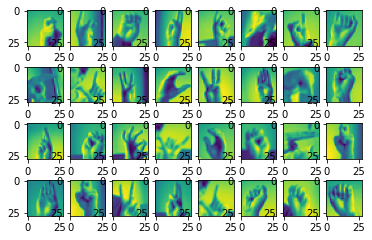

In [4]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Fitting the Data to the Generator

Next, the generator must be fit on the training dataset.

In [5]:
datagen.fit(x_train)

## Compiling the Model

With the data generator instance created and fit to the training data, the model can now be compiled in the same way as our earlier examples:

In [6]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Training with Augmentation

When using an image data generator with Keras, a model trains a bit differently: instead of just passing the `x_train` and `y_train` datasets into the model, we pass the generator in, calling the generator's [flow](https://keras.io/api/preprocessing/image/) method. This causes the images to get augmented live and in memory right before they are passed into the model for training.

Generators can supply an indefinite amount of data, and when we use them to train our data, we need to explicitly set how long we want each epoch to run, or else the epoch will go on indefinitely, with the generator creating an indefinite number of augmented images to provide the model.

We explicitly set how long we want each epoch to run using the `steps_per_epoch` named argument. Because `steps * batch_size = number_of_images_trained in an epoch` a common practice, that we will use here, is to set the number of steps equal to the non-augmented dataset size divided by the batch_size (which has a default value of 32).

Run the following cell to see the results. The training will take longer than before, which makes sense given we are now training on more data than previously:

In [7]:
model.fit(img_iter,
          epochs=10,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/10
858/857 [==============================] - 8s 9ms/step - loss: 1.1181 - accuracy: 0.6405 - val_loss: 0.9490 - val_accuracy: 0.6873
Epoch 2/10
858/857 [==============================] - 7s 8ms/step - loss: 0.3323 - accuracy: 0.8856 - val_loss: 0.7131 - val_accuracy: 0.7734
Epoch 3/10
858/857 [==============================] - 7s 8ms/step - loss: 0.2037 - accuracy: 0.9326 - val_loss: 0.2476 - val_accuracy: 0.9101
Epoch 4/10
858/857 [==============================] - 7s 8ms/step - loss: 0.1583 - accuracy: 0.9462 - val_loss: 0.7825 - val_accuracy: 0.8249
Epoch 5/10
858/857 [==============================] - 7s 8ms/step - loss: 0.1240 - accuracy: 0.9594 - val_loss: 0.0424 - val_accuracy: 0.9872
Epoch 6/10
858/857 [==============================] - 7s 8ms/step - loss: 0.1058 - accuracy: 0.9655 - val_loss: 0.2562 - val_accuracy: 0.9161
Epoch 7/10
858/857 [==============================] - 7s 8ms/step - loss: 0.0978 - accuracy: 0.9691 - val_loss: 0.2122 - val_accuracy: 0.9403
Epoch 

## Discussion of Results

You will notice that the validation accuracy is higher, and more consistent. This means that our model is no longer overfitting in the way it was; it generalizes better, making better predictions on new data.

## Saving the Model

Now that we have a well-trained model, we will want to deploy it to perform inference on new images.

It is common, once we have a trained model that we are happy with to save it to disk.

Saving the model in Keras is quite easy using the save method. There are different formats that we can save in, but we'll use the default for now. If you'd like, feel free to check out [the documentation](https://www.tensorflow.org/guide/keras/save_and_serialize). In the next notebook, we'll load the model and use it to read new sign language pictures:

In [16]:
model.save('asl_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: asl_model/assets


## Summary

In this section you used Keras to augment your dataset, the result being a trained model with less overfitting and excellent validation image results.

### Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory.

In [8]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Next

Now that you have a well-trained model saved to disk, you will, in the next section, deploy it to make predictions on not-yet-seen images.

Please continue to the next notebook: [*Model Predictions*](04b_asl_predictions.ipynb).